# Variational Autoencoder (VAE)

Useful links: 
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [ ]:
#!L
# from gfile import download_list

# download_list(
#     url='https://drive.google.com/file/d/1F96x4LDbsTZGMMq81fZr7aduJCe8N95O',
#     filename='celeba.zip',
#     target_dir='/kaggle/working'
# )

In [ ]:
#!L:bash
# !unzip celeba.zip

## Prepare the data

In [1]:
!python -m pip install -qq lightning

In [1]:
#!L
import os

import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid
import lightning as L

In [2]:
#!L
class CropCelebA64:
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
train_dataset = torchvision.datasets.CelebA(
    root='/kaggle/input/celeba-vae/celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [4]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
#     root='celeba',
    root='/kaggle/input/celeba-vae/celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
#     root='celeba',
    root='/kaggle/input/celeba-vae/celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

In [6]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [5]:
#!L
BATCH_SIZE = 256
nw = os.cpu_count()
# you may find useful parameters `num_workers` and `pin_memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=nw)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=nw)
len(train_loader), len(val_loader)

(636, 78)

In [6]:
import wandb
from kaggle_secrets import UserSecretsClient
wdb_key = UserSecretsClient().get_secret("wandb_api")
wandb.login(key=wdb_key)
from lightning.pytorch.loggers import WandbLogger

wandb: Currently logged in as: nizovskiyka. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [7]:
#!L
# dimZ = 100  # Considering face reconstruction task, which size of representation seems reasonable?
dimZ = 1024 # There are many details on face, thus let's start with a huge representation.
# We will use degrees of 2 for dimz number as it is generally better for compudation speed
# Other dim shall be smth in between dimz and original shape 
dimA = int(64*64 / np.power(2, int(((np.log2(64*64) - np.log2(dimZ))) / 2)))
print(dimZ, dimA)

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

wandb_logger = WandbLogger(project="celeba_ae")

class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()

        enc_input = torch.nn.Linear(64*64, dimA)
        torch.nn.init.xavier_uniform_(enc_input.weight)
        torch.nn.init.constant_(enc_input.bias, 0)
        enc_hidden = torch.nn.Linear(dimA, dimZ)
        torch.nn.init.xavier_uniform_(enc_hidden.weight)
        torch.nn.init.constant_(enc_hidden.bias, 0)

        
        dec_hidden = torch.nn.Linear(dimZ, dimA)
        torch.nn.init.xavier_uniform_(dec_hidden.weight)
        torch.nn.init.constant_(dec_hidden.bias, 0)
        dec_output = torch.nn.Linear(dimA, 64*64)
        torch.nn.init.xavier_uniform_(dec_output.weight)
        torch.nn.init.constant_(dec_output.bias, 0)
        
        self.encoder = torch.nn.Sequential(
            enc_input,
            torch.nn.ReLU(),
            enc_hidden,
        )
        self.decoder = torch.nn.Sequential(
            dec_hidden,
            torch.nn.ReLU(),
            dec_output,
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

1024 2048


In [8]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder()

# Use Adam optimizer
# optimizer = optim.Adam(autoencoder.parameters())

In [9]:

# define the LightningModule
class LitAutoEncoder(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        x_hat, z = self.model(x)
        loss = criterion(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_ = x.view(x.size(0), -1)
        x_hat, z = self.model(x_)
        loss = criterion(x_hat, x_)
        self.log("val_loss", loss)
        if not batch_idx % 10:
            sample = x[0].permute(1,2,0)
            sample_reconstruct = x_hat.view(x.shape)[0].permute(1,2,0)
            img = torch.concat([sample, sample_reconstruct], dim=1)[:,:,0]
            self.logger.log_image(key="reconstruction", images=[img])
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.model.parameters(), lr=1e-4)
        return optimizer


# init the autoencoder
lautoencoder = LitAutoEncoder(autoencoder)

In [10]:
# 16-bit precision
trainer = L.Trainer(
#     precision=16,
    default_root_dir="/kaggle/working/ckpt/",
    max_epochs=26,
    accelerator="gpu",
    logger=wandb_logger,
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(lautoencoder, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params
--------------------------------------
0 | model | Autoencoder | 21.0 M
--------------------------------------
21.0 M    Trainable params
0         Non-trainable params
21.0 M    Total params
83.923    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
#!L
# Train your autoencoder
# Visualize progress in reconstruction and loss decay
# See wandb run for more info.

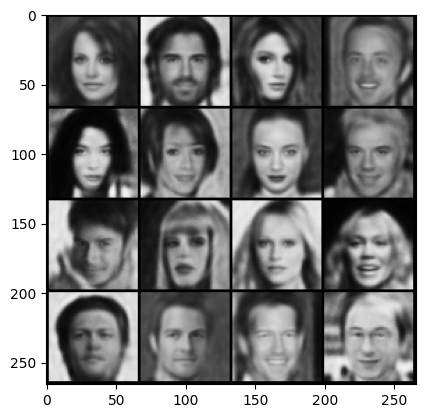

In [43]:
#!L
# Examine the reconstructions
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
images_ = images.view(images.size(0), -1)
reconstruction_, latent_code = autoencoder(images_.to(torch.device("cpu")))
reconstruction = reconstruction_.view(images.shape)
reconstruction = reconstruction[:16].cpu()
plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

-Reconstruction is not bad, right? 

-simply awesome 

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

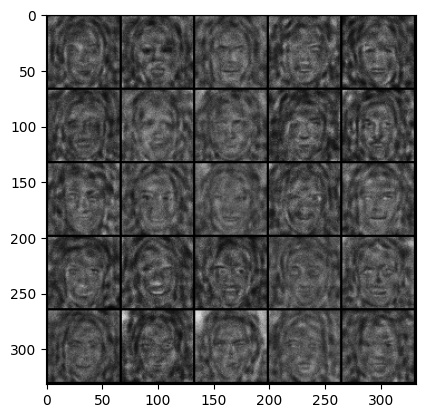

In [49]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction_ = autoencoder.decoder(z.to(torch.device("cpu"))).clamp(0, 1)
reconstruction = reconstruction_.view([25, 1, 64, 64])
plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

-So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

-Hell yeah

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [7]:
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 1024
dimA = int(64*64 / np.power(2, int(((np.log2(64*64) - np.log2(dimZ))) / 2)))

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST
        
wandb_logger_vae = WandbLogger(project="celeba_vae")
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        
        # ENCODER
        self.encoder_fc1 = nn.Linear(64 * 64, dimA)
        self.encoder_fc1.bias.data.fill_(0)
        
        self.encoder_fc_mu = nn.Linear(dimA, dimZ)
        self.encoder_fc_mu.bias.data.fill_(0)
        
        self.encoder_fc_logsigma = nn.Linear(dimA, dimZ)
        self.encoder_fc_logsigma.bias.data.fill_(0)
        
        
        # DECODER
        self.decoder_fc1 = nn.Linear(dimZ, dimA)
        self.decoder_fc1.bias.data.fill_(0)

        self.decoder_fc_mu = nn.Linear(dimA, 64 * 64)
        self.decoder_fc_mu.bias.data.fill_(0)

        self.decoder_fc_logsigma = nn.Linear(dimA, 64 * 64)
        self.decoder_fc_logsigma.bias.data.fill_(0)

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def encode(self, x):
        x = self.encoder_fc1(x)
        x = F.relu(x)
        latent_mu = self.encoder_fc_mu(x)
        latent_logsigma = self.encoder_fc_logsigma(x)
        return latent_mu, latent_logsigma
    
    def decode(self, x):
        x = self.decoder_fc1(x)
        z = F.relu(x)
        reconstruction_mu = torch.sigmoid(self.decoder_fc_mu(x)).view(-1, 1, 64, 64)
        reconstruction_logsigma = self.decoder_fc_logsigma(x).view(-1, 1, 64, 64)
        return reconstruction_mu, reconstruction_logsigma
    
    def forward(self, x):
        latent_mu, latent_logsigma = self.encode(x)
        z = self.gaussian_sampler(latent_mu, latent_logsigma)
        reconstruction_mu, reconstruction_logsigma = self.decode(z)        
        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [8]:
#!L
import math

def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - logsigma.exp().pow(2))


def log_likelihood(x, mu, logsigma):
    return torch.sum(-0.5 * math.log(2 * math.pi) - logsigma - (mu - x).pow(2) / (2 * logsigma.exp().pow(2)))


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen)

And train the model:

In [9]:
#!L
# train your variational autoencoder
# visualize progress in reconstruction and loss decay

In [10]:
class LitVAE(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_ = x.view(-1, 64 * 64)
        mu_gen, logsigma_gen, mu_z, logsigma_z = self.model(x_)
        loss = loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_ = x.view(-1, 64 * 64)
        mu_gen, logsigma_gen, mu_z, logsigma_z = self.model(x_)
        loss = loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z)
        self.log("val_loss", loss)
        if not batch_idx % 10:
            sample = x[0].permute(1,2,0)
            sample_reconstruct = mu_gen.view(x.shape)[0].permute(1,2,0)
            img = torch.concat([sample, sample_reconstruct], dim=1)[:,:,0]
            self.logger.log_image(key="reconstruction", images=[img])
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.model.parameters(), lr=1e-4)
        return optimizer


# init the autoencoder
vae = VAE()
lvae = LitVAE(vae)

In [11]:
trainer = L.Trainer(
#     precision=16,
    max_epochs=26,
    accelerator="gpu",
    logger=wandb_logger_vae,
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


In [12]:
trainer.fit(lvae, train_loader, val_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type | Params
-------------------------------
0 | model | VAE  | 31.5 M
-------------------------------
31.5 M    Trainable params
0         Non-trainable params
31.5 M    Total params
125.886   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=26` reached.


In [21]:
torch.save(lvae, "/kaggle/working/vae.ckpt")

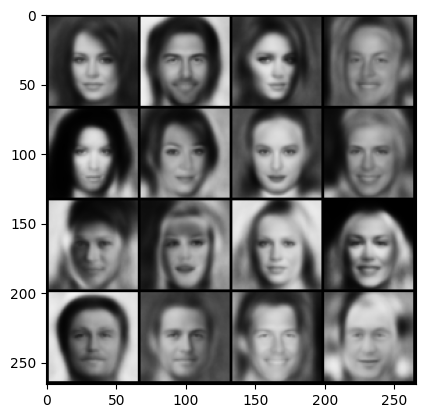

In [15]:
#!L
from itertools import islice

images, _ = list(islice(val_loader, 1))[0]
images_ = images.view(-1, 64 * 64)
mu_gen, _, _, _ = vae(images_.to(torch.device("cpu")))
reconstruction = mu_gen[:16].cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))

And finally sample from VAE.

In [16]:
#!L
# TODO
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
# 2) Sample from N(decoder_mu(z), decoder_sigma(z))

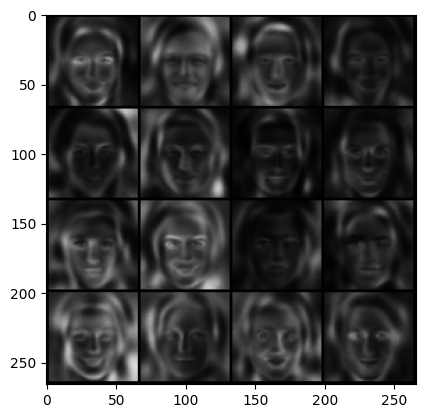

In [18]:
# 1)
z = torch.randn(25, dimZ)
mu_gen, log_sigma = vae.decode(z.to(torch.device("cpu")))
reconstruction = mu_gen[:16].clamp(0, 1).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=4).permute(1, 2, 0))

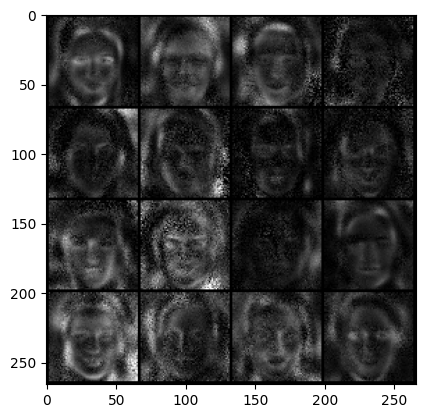

In [19]:
# 2)
sample = mu_gen.cpu() + log_sigma.exp().cpu() * torch.randn(25, 1, 64, 64)
reconstruction = sample[:16].clamp(0, 1).cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=4).permute(1, 2, 0))

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now. 

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it. 

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE. 

<img src="linear.png" alt="linear">

In [80]:
# 1 sample smiling and not-smiling
images, attributes = list(islice(val_loader, 1))[0]
sm_idx = [i for i, at in enumerate(attributes) if at[31] == 1.0]
nsm_idx = [i for i, at in enumerate(attributes) if at[31] == 0.0]

sm_img = [images[s] for s in smiling]
nsm_img = [images[s] for s in not_smiling]

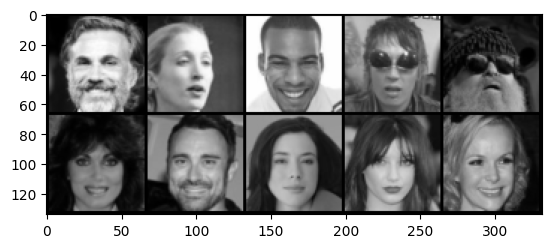

In [115]:
plt.imshow(make_grid(sm_img[80:90], nrow=5).permute(1, 2, 0))

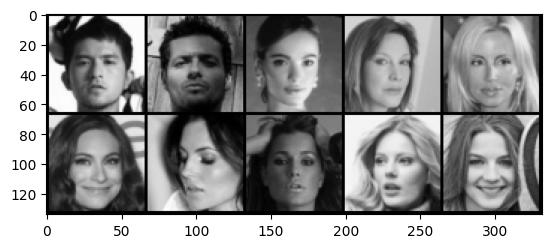

In [127]:
plt.imshow(make_grid(nsm_img[110:120], nrow=5).permute(1, 2, 0))

In [128]:
sm = torch.cat(sm_img[80:90], dim=0).unsqueeze(dim=1)
nsm = torch.cat(nsm_img[110:120], dim=0).unsqueeze(dim=1)

sm_ = sm.view(sm.size(0), -1)
nsm_ = nsm.view(nsm.size(0), -1)

In [129]:
# 2 compute "vector representation" of the "smile" and "no smile" attribute.
with torch.no_grad():
    ae_latent_sm = autoencoder.encoder(sm_)
    vae_latent_sm, _ = vae.encode(sm_)
    
    ae_latent_nsm = autoencoder.encoder(nsm_)
    vae_latent_nsm, _ = vae.encode(nsm_)
    
    ae_diff = torch.mean(ae_latent_sm - ae_latent_nsm, dim=0)
    vae_diff = torch.mean(vae_latent_sm - vae_latent_nsm, dim=0)

In [130]:
# What we want to make these people smiling
tgt = torch.cat(nsm_img[110:120], dim=0).unsqueeze(dim=1).to(torch.device("cpu"))
tgt_ = imgs.view(imgs.size(0), -1)

with torch.no_grad():
    ae_res_ = autoencoder.decoder(autoencoder.encoder(tgt_) + ae_diff.unsqueeze(dim=0))
    vae_res, _ = vae.decode(vae.encode(tgt_)[0] + vae_diff.unsqueeze(dim=0))
ae_res = ae_res_.view(tgt.shape)

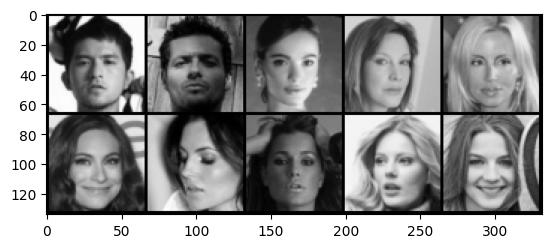

In [134]:
plt.imshow(make_grid(nsm_img[110:120], nrow=5).permute(1, 2, 0))

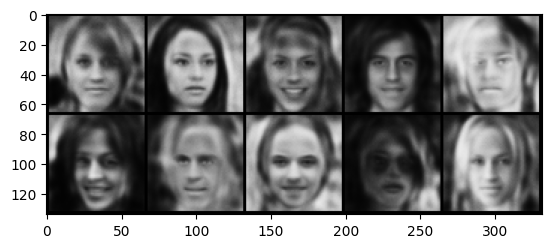

In [132]:
plt.imshow(make_grid(ae_res.clamp(0, 1), nrow=5).permute(1, 2, 0))


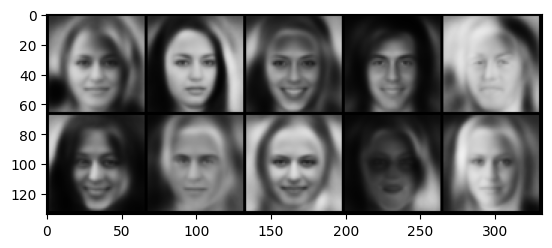

In [133]:
plt.imshow(make_grid(vae_res.clamp(0, 1), nrow=5).permute(1, 2, 0))
